# GMM method analysis and final errors for DS-IB

In [ ]:
# Set to true if on COLAB
USING_COLAB = False

In [ ]:
# If using google colab
if USING_COLAB:
    from google.colab import drive
    drive.mount("/content/gdrive")
    import os
    # Set to the folder the repo was cloned
    os.chdir("/content/gdrive/MyDrive/Colab Notebooks/STRIKE_YOLO_DRIVE/STRIKE_YOLO")

In [ ]:
! pip install .

In [ ]:
NOTEBOOK_CONFIG = {
    "IMG_LENGTH": 0.377,
    "IMG_WIDTH": 0.143,
    "IMG_XDIM": 143,
    "IMG_YDIM": 377,
    "labels_type": "Labelsv0_detect",
    "task": "detect",
    "model:name": "YOLOv0_E2_detect",
}

In [ ]:
# Sample image
n_image = 209
image_path = f"docs/Data/Images/gaussian_{n_image}.png"
label_path = f"docs/Data/{NOTEBOOK_CONFIG['labels_type']}/gaussian_{n_image}.txt"

In [26]:
import os
import pandas as pd
import numpy as np

from datetime import datetime

from matplotlib import pyplot as plt

In [28]:
from scipy.ndimage import laplace
import scipy.io

from skimage.feature import peak_local_max
from adjustText import adjust_text

In [29]:
from PIL import Image

# Load modules

In [ ]:
from helpers.auxiliary_functions import (
    generate_grid,
    parameters_extract,
    checkpoint_error,
)
from helpers.aux_plotter import plot_boxes_gmm, gaussians_labelled, plot_grayscale
from helpers.gaussian_estimation import sum_gaussians, compute_mse

from pipelines.pipelines import ppl_fit_gaussians, ppl_error_estimation

# Data from CNR

## Load
- Real size of the tile is roughly equal to 2 pixel / mm

In [35]:
# Load 400 gaussians
mat = scipy.io.loadmat("docs/Data/db_80beam.mat")
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'F_data', 'Fit_flux', 'beta'])


In [36]:
# Generate GRID
x, y = generate_grid(
    (0, NOTEBOOK_CONFIG["IMG_WIDTH"]),
    (0, NOTEBOOK_CONFIG["IMG_LENGTH"]),
    NOTEBOOK_CONFIG["IMG_XDIM"],
    NOTEBOOK_CONFIG["IMG_YDIM"],
)

## Box of the gaussians - using dispersion_x and dispersion_y (from true parameters)

In [ ]:
# Load data
# Image - z intensities
image = [x, y, mat["F_data"][:, :, n_image]]

# Parameters extraction
amplitude, xs, ys, dispersion_x, dispersion_y = parameters_extract(
    mat["Fit_flux"], n_image
)

In [ ]:
# Structure covariances
covariances = [
    np.diag(cov)
    for cov in zip((dispersion_x / np.sqrt(2)) ** 2, (dispersion_y / np.sqrt(2)) ** 2)
]

Number of indentifiable Gaussians (center in the image): 79


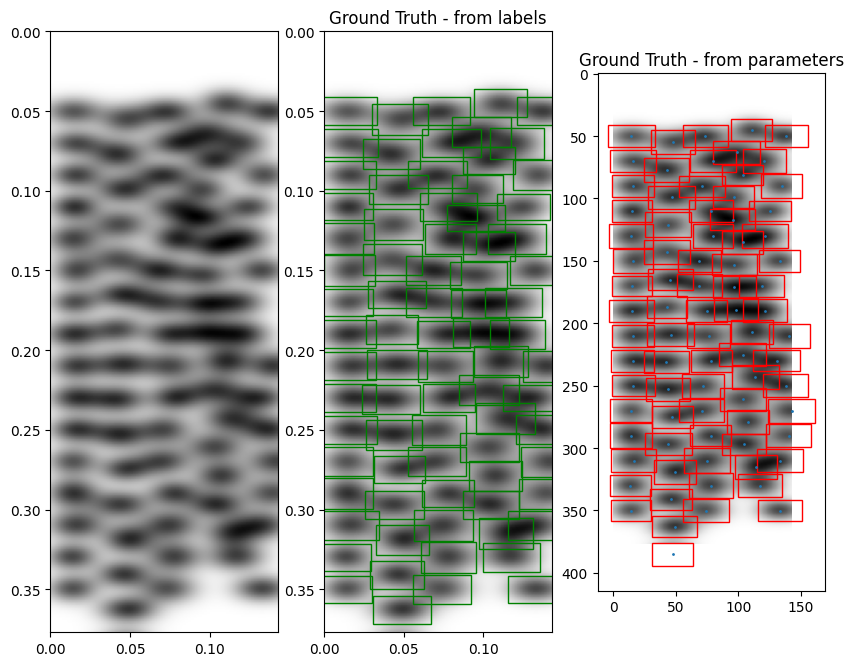

In [ ]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, axs = plt.subplots(1, 3, figsize=(10, 10))

# Display the image
axs[2].imshow(im)
plot_boxes_gmm(means=list(zip(xs, ys)), covariances=covariances, ax=axs[2], beta=3)
axs[2].set_title("Ground Truth - from parameters")
axs[2].scatter(xs * 1000, ys * 1000, s=1)

# Labelling
x, y, z = gaussians_labelled(
    image_path, label_path, axs[1], task=NOTEBOOK_CONFIG["task"], colorbar=False
)
axs[1].set_title("Ground Truth - from labels")

# Image
plot_grayscale(x, y, z, colorbar=False, ax=axs[0])

axs[0].invert_yaxis()
axs[1].invert_yaxis()

axs[2].set_xlim(0, NOTEBOOK_CONFIG["IMG_XDIM"])
axs[2].set_ylim(0, NOTEBOOK_CONFIG["IMG_YDIM"])
axs[2].invert_yaxis()

for ax in axs:
    ax.xaxis.label.set_text("")
    ax.yaxis.label.set_text("")

# [ESTIMATION PART II]
- Images: 200 - 400
- Amplitudes: All amplitudes are higher around 2E6 (350%)
- x center: It has some Gaussians deslocated to left and others to right around 0.004 in x direction
- y center: Coincides with beta ys
- dispersion x : Higher dispersion in x direction around 0.006 (60%)
- dispersion y : Higher dispersion in y direction around 0.003 (60%)

## [ESTIMATION] Pipeline ppl_SCIKIT_GMM
- Processing using Scikit-image library
- Mean and covariances from GMM

In [37]:
# Load data
# Image - z intensities
image = [x, y, mat["F_data"][:, :, n_image]]

# Parameters extraction
amplitude, xs, ys, dispersion_x, dispersion_y = parameters_extract(
    mat["Fit_flux"], n_image
)

### Centers estimation

In [38]:
# Find local maxima coordinates
coordinates = peak_local_max(image[2], min_distance=1)

# 2D plot in grayscale - selected image for initial development
fig, ax = plt.subplots()
plot_grayscale(x, y, image[2], ax)
ax.scatter(image[0][0, [coordinates[:, 1]]], image[1][coordinates[:, 0], 0], s=5)

In [39]:
# Find local maxima coordinates
z_laplace = laplace(image[2])
z_laplace[np.nonzero(z_laplace >= 0)] = 0
coordinates = peak_local_max(-1 * z_laplace, min_distance=1)

# 2D plot in grayscale - selected image for initial development
fig, ax = plt.subplots()
plot_grayscale(x, y, image[2], ax)
ax.scatter(image[0][0, [coordinates[:, 1]]], image[1][coordinates[:, 0], 0], s=5)

In [40]:
# Thresholding laplacian
# histogram of values
histogram, bin_edges = np.histogram(-1 * laplace(image[2]), bins=100)

fig, ax = plt.subplots()
ax.plot(bin_edges[0:-1], histogram)

fig, ax = plt.subplots()
plot_grayscale(x, y, laplace(image[2]), ax)

In [41]:
# Estimate Gaussian - Final prediction
(means, covariances, angles, amplitudes) = ppl_fit_gaussians(
    image,
    means_init="laplace",
    peak_method="laplace",
    em_iterations=1000,
    covariance_gaussians_type="diag",
    n_gaussians=None,
    image_ranges=[
        (0, NOTEBOOK_CONFIG["IMG_WIDTH"]),
        (0, NOTEBOOK_CONFIG["IMG_LENGTH"]),
    ],
    image_size=[NOTEBOOK_CONFIG["IMG_XDIM"], NOTEBOOK_CONFIG["IMG_YDIM"]],
    fig_size=(10, 8),
    plot=True,
    plot_points=True,
)

estimate_parameters_gmm executed in 3.1771929264068604 seconds
ppl_fit_gaussians executed in 4.759583473205566 seconds


Number of indentifiable Gaussians (center in the image): 79


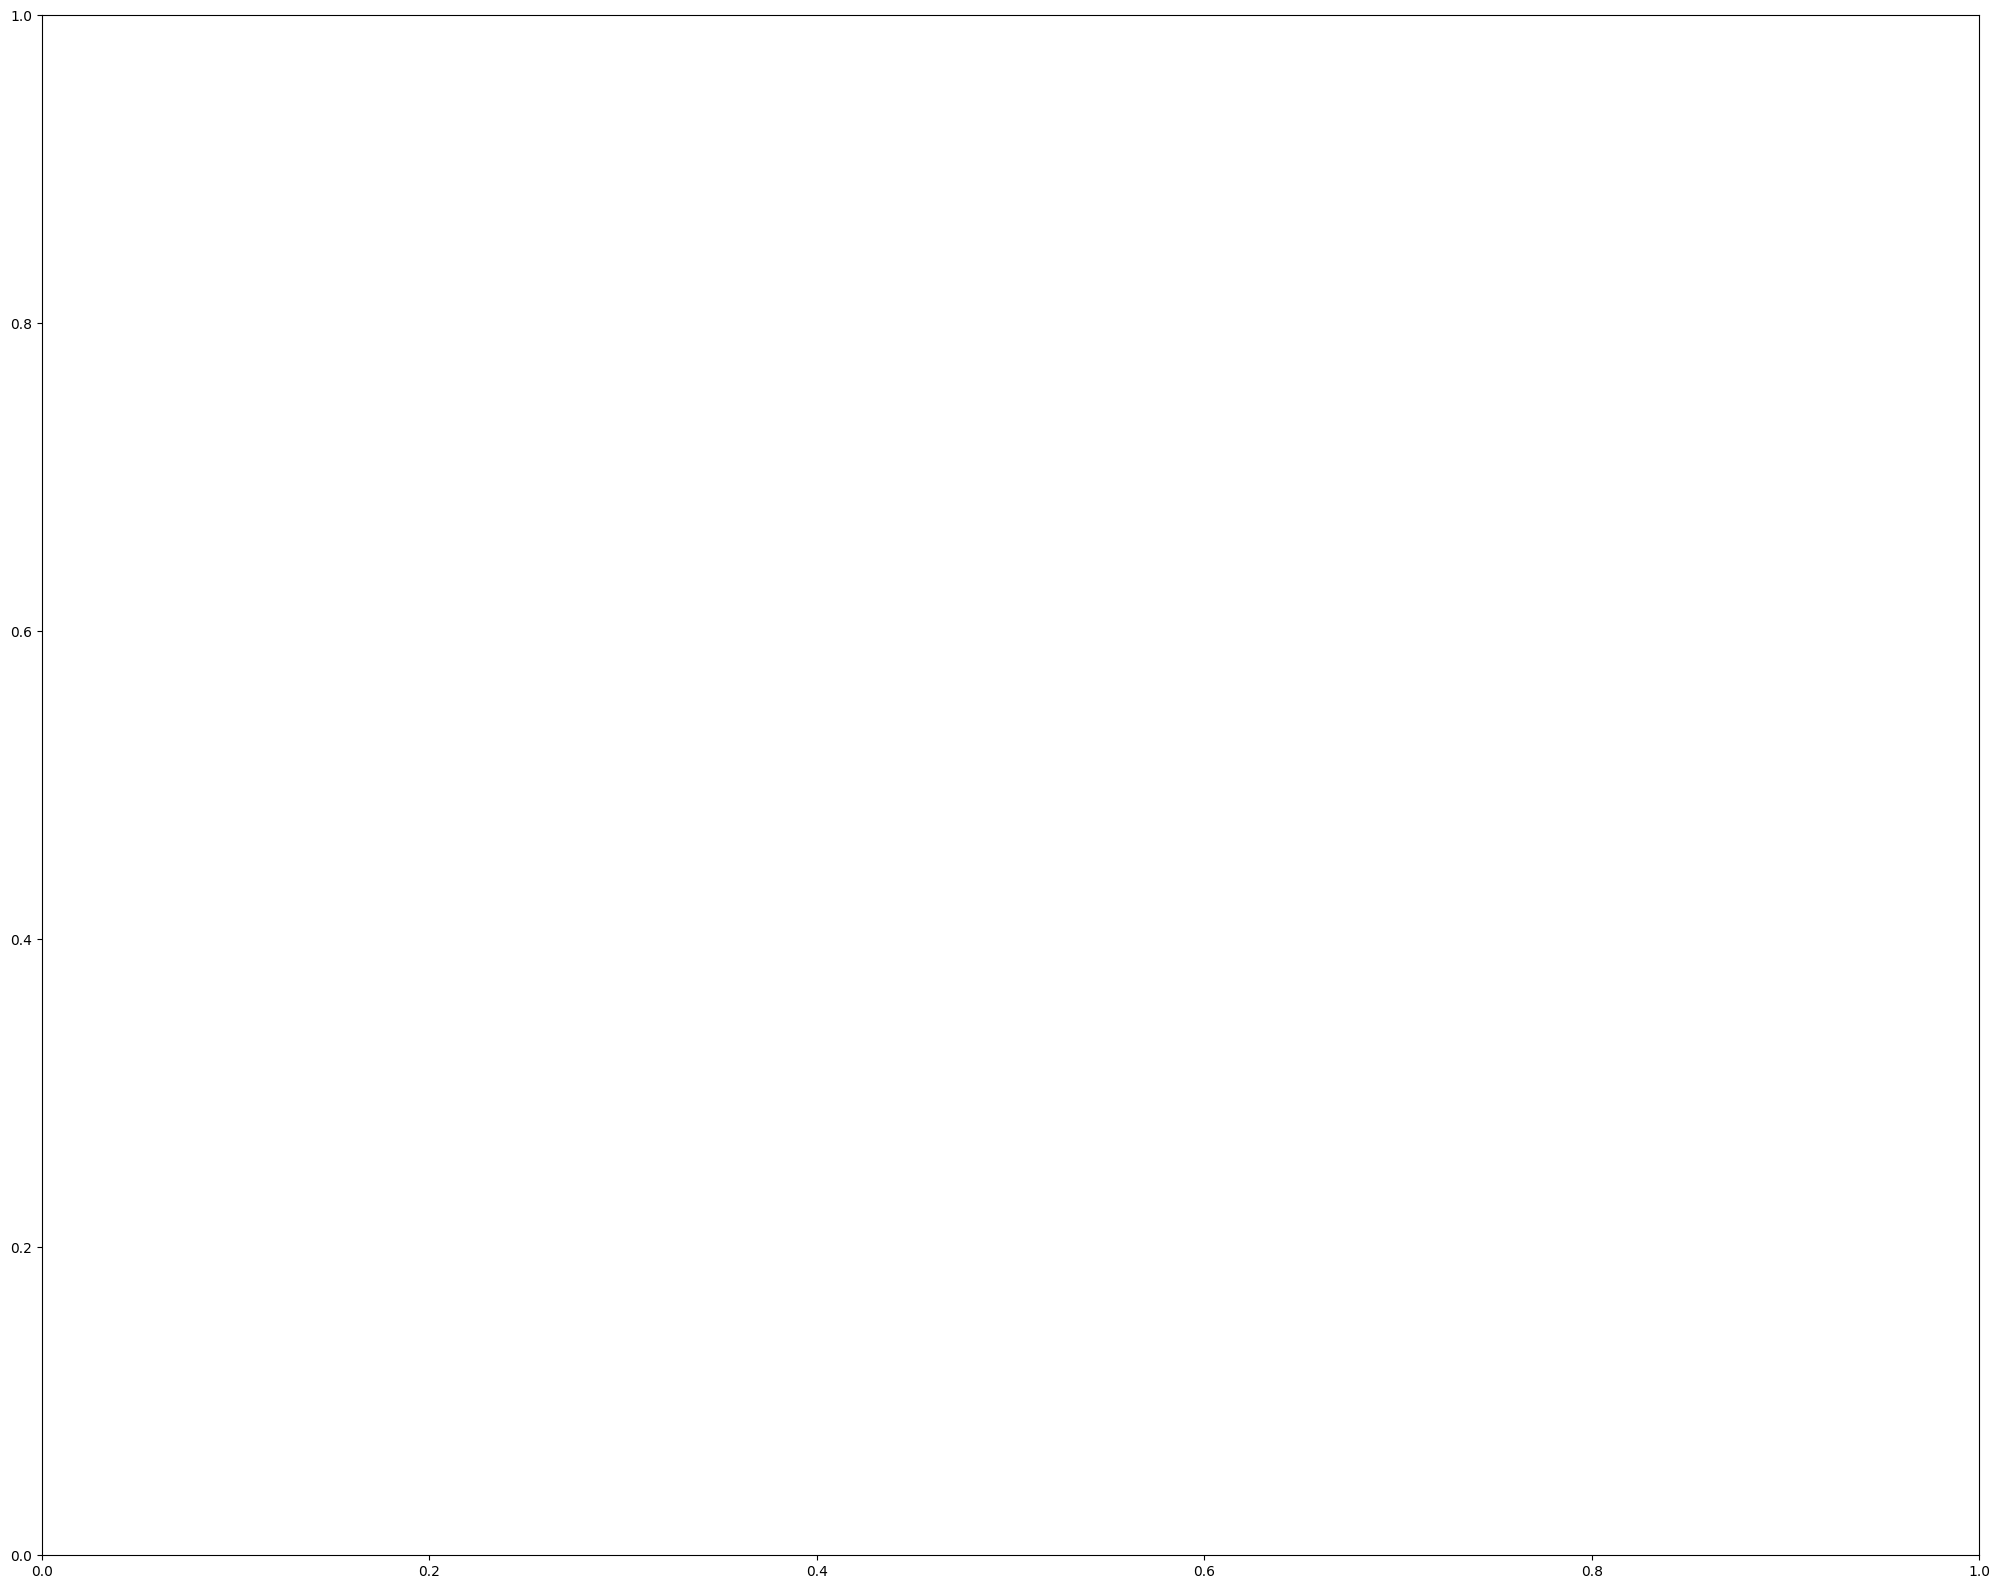

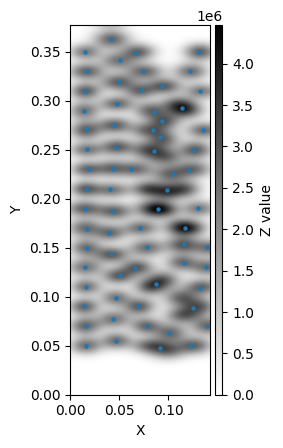

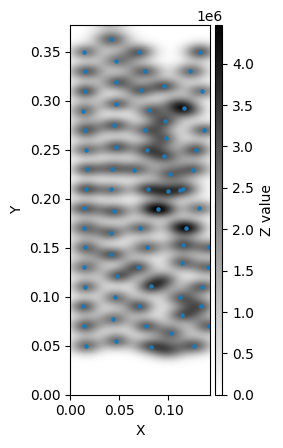

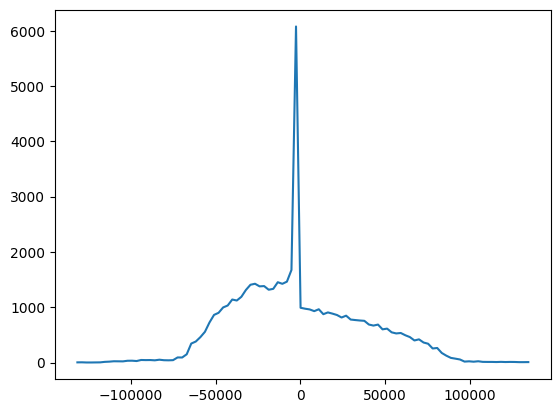

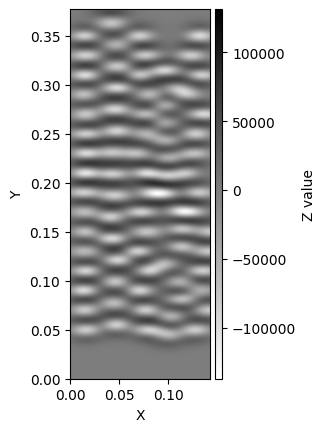

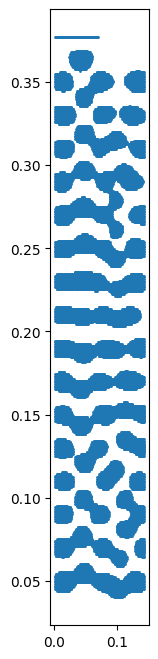

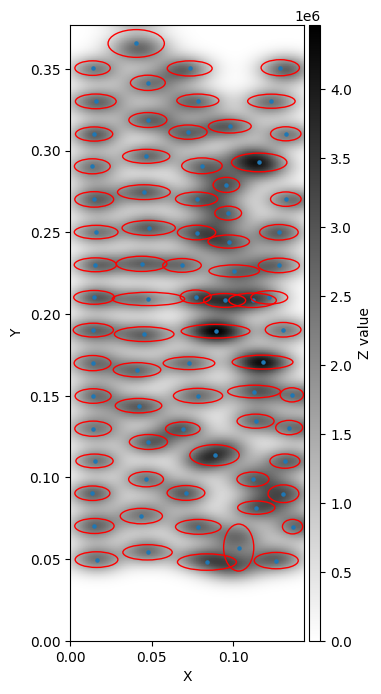

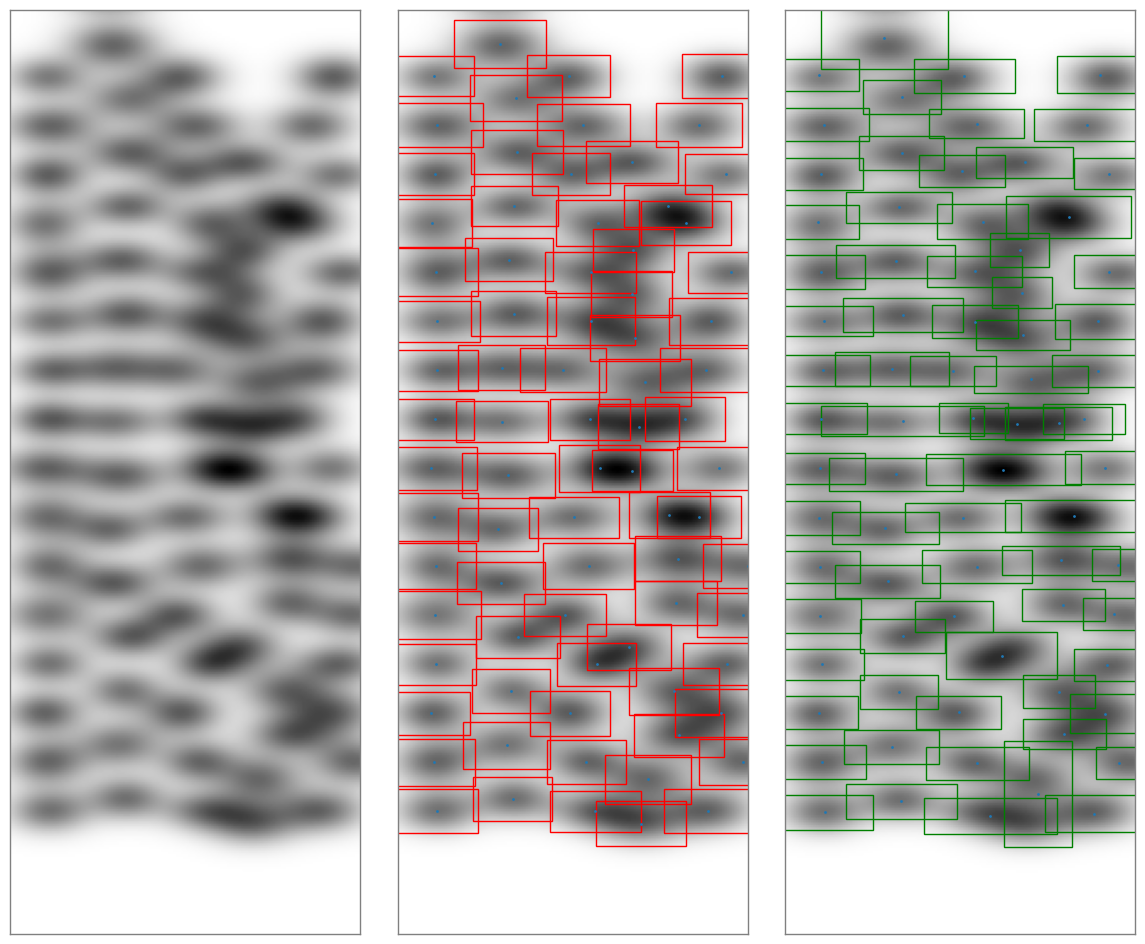

In [43]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, axs = plt.subplots(1, 3, figsize=(15, 12))

# Display the image and plot predicted centers
axs[2].imshow(im)
plot_boxes_gmm(means=means, covariances=covariances, ax=axs[2], beta=3, edge_color="g")
axs[2].set_ylim(ax.get_ylim()[::-1])
axs[2].scatter(means[:, 0] * 1000, means[:, 1] * 1000, s=1)
# axs[2].axis('off')
axs[2].set_xlim(0, NOTEBOOK_CONFIG["IMG_XDIM"])
axs[2].set_ylim(0, NOTEBOOK_CONFIG["IMG_YDIM"])

# axs[2].set_title("Prediction")

# Labelling
x, y, z = gaussians_labelled(
    image_path,
    label_path,
    axs[1],
    task=NOTEBOOK_CONFIG["task"],
    colorbar=False,
    plot_centers=True,
)
# axs[1].axis('off')
axs[1].set_xlim(0, NOTEBOOK_CONFIG["IMG_WIDTH"])
axs[1].set_ylim(0, NOTEBOOK_CONFIG["IMG_LENGTH"])
# axs[1].set_title("Ground Truth")

# Image
plot_grayscale(x, y, z, colorbar=False, ax=axs[0])
# axs[0].axis('off')
axs[0].set_xlim(0, NOTEBOOK_CONFIG["IMG_WIDTH"])
axs[0].set_ylim(0, NOTEBOOK_CONFIG["IMG_LENGTH"])


for ax in axs:
    ax.xaxis.label.set_text("")
    ax.yaxis.label.set_text("")

    ax.set_xticks([])
    ax.set_yticks([])
    # Change the color of the axis spines (borders)
    for spine in ax.spines.values():
        spine.set_edgecolor("gray")
        spine.set_linewidth(1)

plt.subplots_adjust(wspace=0)
plt.show()

### Error evaluation
- Dispersion_x in the mat file is equal to sqrt(2) * sigma_x, same for y direction

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(
    f"docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/"
)
eval_images = [
    int(i.split("_")[1].split(".")[0]) for i in images_test
]  # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[277, 204, 385, 217, 257, 285, 310, 306, 334, 241, 363, 253, 348, 349, 203, 274, 292, 395, 364, 239]


In [ ]:
# Iterate all images - GMM method
results = {
    "Image": [],
    "Number identified - gmm": [],
    "Number identifiable - gmm": [],
    "Percentage - gmm": [],
    "RMSE_cx - gmm": [],
    "RMSE_cy - gmm": [],
    "RMSE_c - gmm": [],
    "RMSE_sigmax - gmm": [],
    "RMSE_sigmay - gmm": [],
    "RMSE_sigma - gmm": [],
    "RMSE_amplitude - gmm": [],
    "MaxE_sigmax - gmm": [],
    "MaxE_sigmay - gmm": [],
    "MaxE_sigma - gmm": [],
    "RMSE_amplitude - gmm": [],
    "RMSEPixel - gmm": [],
}

for n_image in eval_images:
    eval_gaussian = ppl_error_estimation(
        n_image,
        mat,
        peak_method="laplace",
        estimation_method="gmm",
        covariance_gaussians_types="diag",
        return_percentage=True,
    )
    # Append values in the dictionary
    for key in results.keys():
        if key in eval_gaussian:
            results[key] += eval_gaussian[key]

estimate_parameters_gmm executed in 3.656445264816284 seconds
ppl_fit_gaussians executed in 3.6904053688049316 seconds
covariances [[[   0.010807           0]
  [          0   0.0046427]]]
covariances true [[[   0.015023           0]
  [          0   0.0082576]]]
estimate_parameters_gmm executed in 2.5860352516174316 seconds
ppl_fit_gaussians executed in 2.6124587059020996 seconds
covariances [[[   0.015915           0]
  [          0   0.0048602]]]
covariances true [[[   0.016803           0]
  [          0   0.0079174]]]
estimate_parameters_gmm executed in 3.8108417987823486 seconds
ppl_fit_gaussians executed in 3.8910012245178223 seconds
covariances [[[   0.017925           0]
  [          0   0.0043982]]]
covariances true [[[   0.017615           0]
  [          0   0.0086341]]]
estimate_parameters_gmm executed in 4.610746145248413 seconds
ppl_fit_gaussians executed in 4.647645711898804 seconds
covariances [[[   0.015597           0]
  [          0   0.0044192]]]
covariances true [

In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[["mean", "std", "max"]].T

,mean,std,max
Image,294.80,59.84,395.00
Number identified - gmm,75.70,1.56,78.00
Number identifiable - gmm,79.00,0.00,79.00
Percentage - gmm,95.82,1.97,98.73
RMSE_cx - gmm,2.56,0.30,3.06
RMSE_cy - gmm,0.46,0.25,1.39
RMSE_c - gmm,2.61,0.32,3.17
RMSE_sigmax - gmm,25.24,0.87,26.94
RMSE_sigmay - gmm,47.56,0.60,48.54
RMSE_sigma - gmm,53.84,0.76,55.07


In [ ]:
pd.DataFrame.from_dict(results).round(2)

,Image,Number identified - gmm,Number identifiable - gmm,Percentage - gmm,RMSE_cx - gmm,RMSE_cy - gmm,RMSE_c - gmm,RMSE_sigmax - gmm,RMSE_sigmay - gmm,RMSE_sigma - gmm,RMSE_amplitude - gmm,MaxE_sigmax - gmm,MaxE_sigmay - gmm,MaxE_sigma - gmm,RMSEPixel - gmm
0,277,75,79,94.94,2.56,0.34,2.58,25.59,47.25,53.73,8.43,61.34,56.93,83.68,523116.39
1,204,78,79,98.73,2.40,0.65,2.48,24.05,47.29,53.05,9.87,45.84,57.02,73.17,543895.77
2,385,76,79,96.20,2.36,0.51,2.42,25.68,47.13,53.67,11.39,56.68,54.44,78.60,560169.96
3,217,74,79,93.67,3.03,0.37,3.05,25.38,47.04,53.45,10.76,54.68,56.67,78.75,534121.58
4,257,73,79,92.41,2.83,0.36,2.85,24.81,47.33,53.44,10.49,54.53,58.62,80.06,523093.71
5,285,76,79,96.20,2.33,0.30,2.35,25.58,48.28,54.64,9.42,61.24,56.59,83.38,533920.17
6,310,78,79,98.73,2.84,1.39,3.17,26.44,48.17,54.95,9.24,58.87,56.46,81.57,535133.02
7,306,74,79,93.67,2.56,0.37,2.59,23.77,47.72,53.31,9.99,53.25,61.40,81.28,521494.12
8,334,77,79,97.47,2.92,0.32,2.94,25.25,47.60,53.88,8.34,59.34,55.98,81.58,528269.76
9,241,76,79,96.20,2.64,0.30,2.65,24.62,47.43,53.44,9.76,53.01,56.98,77.83,525817.25


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(
    snapshot_folder_path=snapshot_folder_path,
    error_dataframe=pd.DataFrame.from_dict(results).sort_values("Image"),
    annotation=f"""Amplitudes estimated using the center directly\n
                 image_path = {images_test}\n
                 id_estimation_method = {"GMM - random state 13 - 200 - 400 images"}\n
                 id_images evaluated: {eval_images}""",
    name="E2GMM",
)

#### Total error

In [ ]:
# Computing error
gaussians = list(zip(means, covariances, amplitudes))

# Generate image from Gaussians and compute MSE
generated_image = sum_gaussians(x, y, gaussians)
mse = compute_mse(image[2], generated_image)